Here we provide a demonstration of the main functions. We also produce key results, including properties of the multifractal loss landscape, dynamical phenomena, and solution to fractional Langevin equation.  

# Multifractal loss landscape
To generate the multifractal loss landscape, 1)install Fraclab on MATLAB from https://project.inria.fr/fraclab/, 2) run the mBm2DQuantifKrigeage function with user-defined pointwise Holder exponent, 3) save the loss landscape in a mat file. An example landscape is provided in (link to data).

To conduct multifractal analysis, install PLBMF toolbox on MATLAB from https://www.irit.fr/~Herwig.Wendt/software.html and apply wavelet leaders formalism.

<ipython-input-17-be53d8de952b>:39: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_max = interpolate.interp2d(np.arange(max_eig.shape[0]), np.arange(
<ipython-input-17-be53d8de952b>:41: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` ins

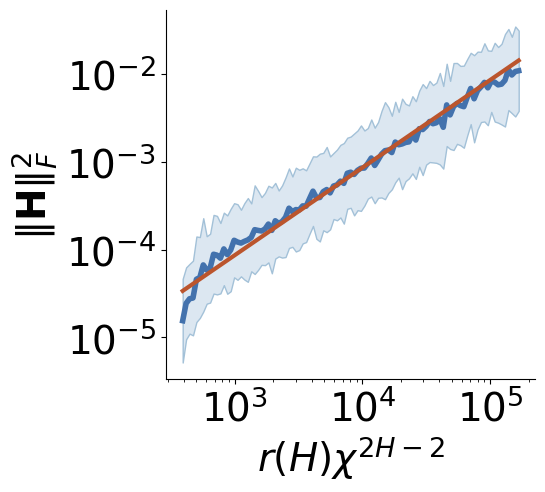

In [17]:
from scipy.io import loadmat
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from multifractal_gd.hessian_tools import hessian, diagonalise_hessian
from multifractal_gd.general_tools import squarify
from scipy import optimize

BIGGER_SIZE = 28
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

data = loadmat("data/multifractional_brownian_surface/landscape.mat")
landscape = data["landscape"]

# 10,000 unique random grid points on loss landscape
np.random.seed(0)
x = np.random.randint(1,1023, 10000)
y = np.random.randint(1,1023, 10000)

# Pointwise Holder exponent
H = 0.5 + 0.2 * np.sin(np.pi * x/512) * np.cos(3*np.pi*y/2048)
rhs = (16 - 2**(2*H + 2) + 2**(2*H) - 2**(3*H-1)) / 1024**(2*H-2)

# Curvature
hess = hessian(landscape) # calculate hessian at each point
eigenvalues = diagonalise_hessian(hess) # Calculate eigenvalues at each point
max_eig = np.squeeze(eigenvalues[:,1,:,:]) # Maximum eigenvalues at each point
min_eig = np.squeeze(eigenvalues[:,0,:,:]) # Minimum eigenvalues at each point
# Find max eigenvalue at each point in trajectory by linear interpolation
curv = []
f_max = interpolate.interp2d(np.arange(max_eig.shape[0]), np.arange(
    max_eig.shape[1]), max_eig, kind='linear') # function for linear interpolation
f_min = interpolate.interp2d(np.arange(min_eig.shape[0]), np.arange(
    min_eig.shape[1]), min_eig, kind='linear') # function for linear interpolation
for i in range(len(x)):
    x_tmp = x[i]
    y_tmp = y[i]
    curv.append( (np.abs(f_max(x_tmp,y_tmp)))**2 + (np.abs(f_min(x_tmp,y_tmp)))**2 )
curv = np.array(curv).flatten()

x_space = np.logspace(np.log10(np.min(rhs)), np.log10(np.max(rhs)), 100)
rhs_log_mean = np.zeros(len(x_space) - 1)
curv_log_mean = np.zeros(len(x_space) - 1)
curv_log_std = np.zeros(len(x_space) - 1)
for i in range(len(x_space) - 1):
    x_bot = x_space[i]
    x_top = x_space[i+1]
    inside_idx = np.argwhere((rhs >= x_bot) & (rhs <= x_top))
    rhs_log_mean[i] = np.log10(x_bot) + (np.log10(x_top) - np.log10(x_bot))/2
    curv_log_mean[i] = np.log10(np.mean(curv[inside_idx])) # log of mean
    curv_log_std[i] = np.std(np.log10(curv[inside_idx])) # std of log

# Convert values back to linear
rhs_mean = 10**rhs_log_mean
curv_mean = 10**curv_log_mean
curv_top = 10**(curv_log_mean + curv_log_std)
curv_bot = 10**(curv_log_mean - curv_log_std)

fig, ax = plt.subplots()
ax.loglog(rhs_mean, curv_mean, c='#4372AD', linewidth=4, linestyle='-')
ax.fill_between(rhs_mean, curv_bot, curv_top, alpha=1, facecolor='#DCE7F1', edgecolor='#A3C1D8')

def func(x,m):
    return np.log10(m*x)
popt,pcov = optimize.curve_fit(func, 10**rhs_log_mean, curv_log_mean)

X = np.array([10**np.min(rhs_log_mean),10**np.max(rhs_log_mean)])
ax.loglog(X, popt[0]*X, c='#BB552D', linestyle='-', linewidth=3)

ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel(r'$r(H) \chi^{2H-2}$')
ax.set_ylabel(r'$\Vert \mathbf{H} \Vert_F^2$')

ax.set_yticks([1e-5,1e-4,1e-3,1e-2])

squarify(fig)
# fig.savefig("figures/roughness_flatness.pdf", dpi=600, bbox_inches='tight')
plt.show()

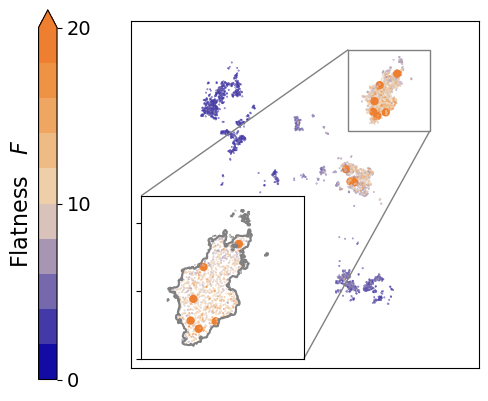

In [14]:
import numpy as np
from multifractal_gd.hessian_tools import hessian, diagonalise_hessian
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load a landscape
lpath = 'data/multifractional_brownian_surface/landscape.mat' # Path to landscape
landscape = loadmat(lpath)["landscape"]
hess = hessian(landscape) # calculate hessian at each point
eigenvalues = diagonalise_hessian(hess) # Calculate eigenvalues at each point

# Find local minima on landscape
x_minima = []
y_minima = []
loss_minima = []
flat_minima = []

for x in range(1,1023):
    for y in range(1,1023):
        loss = landscape[x,y]
        surrounding = np.array([landscape[x+1,y], landscape[x-1,y], landscape[x,y+1], landscape[x,y-1]])
        if np.all(surrounding > loss):
            x_minima.append( x )
            y_minima.append( y )
            loss_minima.append( loss )
            flat_minima.append( 1/np.sqrt(np.linalg.norm(eigenvalues[0,:,x,y])) )

x_minima = np.array(x_minima)
y_minima = np.array(y_minima)
loss_minima = np.array(loss_minima)
flat_minima = np.array(flat_minima)

# Plot
fig, ax = plt.subplots()
xmin = 0; xmax = 1024; ymin = 0; ymax = 1024
nlevels = 5
level_spacing = (np.max(landscape) - np.min(landscape))/nlevels
levels = np.array([np.min(landscape) + i*level_spacing for i in range(1,nlevels)])

cmaplist = ['#130CA4', '#443AA7', '#7568AD', '#A695B3', '#D8C2BA', '#EFCFAA', '#EEBB85', '#EEA662', '#EE9343', '#EE7F31']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))
bounds = np.linspace(0, 20, len(cmaplist)+1)
norm = matplotlib.colors.BoundaryNorm(bounds, len(cmaplist))

# Subset of 3000 lowest loss minima
x_low_minima = x_minima[np.argsort(loss_minima)[:3000]]
y_low_minima = y_minima[np.argsort(loss_minima)[:3000]]
# Of this, separate by flatness
low_flat_minima = flat_minima[np.argsort(loss_minima)[:3000]]

# With colormap
flat_sorted = np.sort(low_flat_minima)
s = low_flat_minima >= flat_sorted[-10]
s = s * 25 + 0.1
img = ax.scatter(y_low_minima,x_low_minima,c=low_flat_minima,s=s,cmap=cmap, vmin=0, vmax=20)

ax.set_xlim([0,1024])
ax.set_ylim([0,1024])
ax.set_aspect('equal')

ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(img, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, pad=0.15, extend='max', location='left')
cbar.ax.yaxis.set_ticks_position('right')
cbar.set_ticks([0,10,20])
cbar.set_label(r'Flatness   $F$', fontsize=16)

##### Zoom in on a cluster #####
axins = zoomed_inset_axes(ax, zoom=2, loc='lower left')
axins.set_xticks([])
axins.set_xticks([])
axins.scatter(y_low_minima,x_low_minima,c=low_flat_minima,s=s,cmap=cmap, vmin=0, vmax=20)
levels = [-1.35]
cs = axins.contour(np.arange(xmin,xmax), np.arange(ymin,ymax), landscape, levels=levels, colors='#808080', vmin=np.min(landscape), vmax=np.max(landscape), alpha=1, linestyles='-')
# subregion of the original image
x1, x2, y1, y2 = 640, 880, 700, 940
axins.set_xlim([x1, x2])
axins.set_ylim([y1, y2])
axins.tick_params(labelleft=False, labelbottom=False)
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
# fig.savefig("figures/clusters.pdf", dpi=600, bbox_inches='tight')
plt.show()

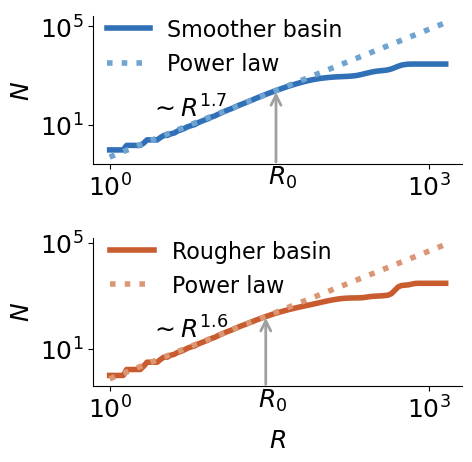

In [13]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from multifractal_gd.general_tools import squarify

##### Set parameters for simulation #####
lpath = 'data/multifractional_brownian_surface/landscape.mat' # Path to landscape
landscape = loadmat(lpath)["landscape"]

##### Find local minima on landscape #####
x_minima = []
y_minima = []
loss_minima = []

for x in range(1,1023):
    for y in range(1,1023):
        loss = landscape[x,y]
        surrounding = np.array([landscape[x+1,y], landscape[x-1,y], landscape[x,y+1], landscape[x,y-1]])
        if np.all(surrounding > loss):
            x_minima.append( x )
            y_minima.append( y )
            loss_minima.append( loss )

x_minima = np.array(x_minima)
y_minima = np.array(y_minima)
loss_minima = np.array(loss_minima)

# Subset of 3000 lowest loss minima
x_low_minima = x_minima[np.argsort(loss_minima)[:3000]]
y_low_minima = y_minima[np.argsort(loss_minima)[:3000]]

##### Minima in smooth cluster #####
y_smooth_cluster = y_low_minima[(y_low_minima > 670) & (y_low_minima < 810) & (x_low_minima > 700) & (x_low_minima < 950)]
x_smooth_cluster = x_low_minima[(y_low_minima > 670) & (y_low_minima < 810) & (x_low_minima > 700) & (x_low_minima < 950)]

##### Minima in rough cluster #####
y_rough_cluster = y_low_minima[(y_low_minima > 200) & (y_low_minima < 300) & (x_low_minima > 710) & (x_low_minima < 860)]
x_rough_cluster = x_low_minima[(y_low_minima > 200) & (y_low_minima < 300) & (x_low_minima > 710) & (x_low_minima < 860)]

##### Clustering analysis #####
distance_thresholds = np.logspace(0,np.log10(1024 * np.sqrt(2)),100)

##### For smooth cluster #####
smooth_count = np.zeros(distance_thresholds.shape[0])
for i in range(x_smooth_cluster.shape[0]):
    x,y = x_smooth_cluster[i], y_smooth_cluster[i]
    distances = np.sqrt(np.square(x_low_minima - x) + np.square(y_low_minima - y))
    for j in range(smooth_count.shape[0]):
        threshold = distance_thresholds[j]
        smooth_count[j] += np.sum(distances < threshold)
smooth_count /= x_smooth_cluster.shape[0]

##### For rough cluster #####
rough_count = np.zeros(distance_thresholds.shape[0])
for i in range(x_rough_cluster.shape[0]):
    x,y = x_rough_cluster[i], y_rough_cluster[i]
    distances = np.sqrt(np.square(x_low_minima - x) + np.square(y_low_minima - y))
    for j in range(rough_count.shape[0]):
        threshold = distance_thresholds[j]
        rough_count[j] += np.sum(distances < threshold)
rough_count /= x_rough_cluster.shape[0]

BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(2,1)
ax1,ax2 = ax

ax1.loglog(distance_thresholds,smooth_count, '-', label='Smoother basin', c='#3070B7', linewidth=4)
ax1.loglog(distance_thresholds,0.51475524 * distance_thresholds ** 1.72185355, c='#6FA4D1', linestyle=':', label='Power law', linewidth=4)
ax1.annotate("", xy=(36.7, 283), xytext=(36.7, 0.25), 
            arrowprops=dict(arrowstyle="->", color='#A0A0A0', linewidth=2))
fig.text(0.3, 0.67, r'$\sim R^{1.7}$')
fig.text(0.485, 0.53, r'$R_0$')
ax1.set_ylabel(r'$N$')
ax1.set_xlabel('')
ax1.legend(fontsize=16, frameon=False, loc=1, bbox_to_anchor=(0.73, 1.12), handlelength=1.9)
ax1.set_xticks([1e0,1e3])
ax1.set_yticks([1e1,1e5])

ax2.loglog(distance_thresholds,rough_count, '-', label='Rougher basin', c='#C95C2E', linewidth=4)
ax2.loglog(distance_thresholds,0.74575158 * distance_thresholds ** 1.60488979, c='#DB9674', linestyle=':', label='Power law', linewidth=4)
ax2.annotate("", xy=(29.4, 190), xytext=(29.4, 0.36),
            arrowprops=dict(arrowstyle="->", color='#A0A0A0', linewidth=2))
fig.text(0.3, 0.21, r'$\sim R^{1.6}$')
fig.text(0.47, 0.065, r'$R_0$')
ax2.set_ylabel(r'$N$')
ax2.set_xlabel(r'$R$')
ax2.legend(fontsize=16, frameon=False, loc=1, bbox_to_anchor=(0.7, 1.12))
ax2.set_xticks([1e0,1e3])
ax2.set_yticks([1e1,1e5])

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

plt.subplots_adjust(hspace=0.5)

squarify(fig)
# fig.savefig("figures/cluster_quantitative.pdf", dpi=600, bbox_inches='tight')
plt.show()

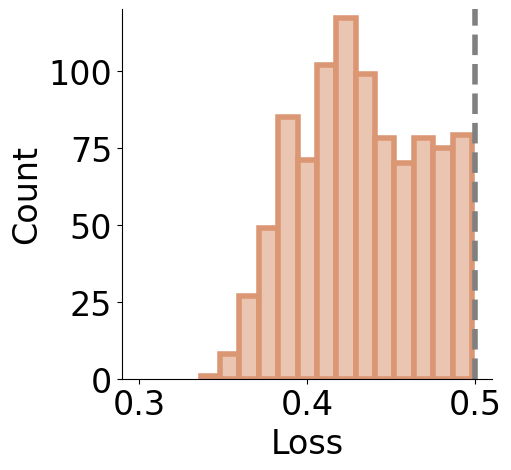

0.4982466108230592
0.3368419086124397
3.171112711402741


In [15]:
from multifractal_gd.general_tools import squarify
import matplotlib.pyplot as plt
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# Histogram of loss of the minima in this region 
idx = (y_low_minima > 650) & (y_low_minima < 900) & (x_low_minima > 700) & (x_low_minima < 950)
fig, ax = plt.subplots()
ax.hist(np.sort(loss_minima)[:3000][idx] - np.min(landscape), bins='auto', linewidth=4, edgecolor='#DB9674', fc='#EAC5B2')
ax.vlines(x=[0.5], ymin=0, ymax=120, color='#808080', linewidth=4, linestyle='--')
ax.set_xlim([0.29,0.51])
ax.set_ylim([0,120])
ax.set_xlabel('Loss')
ax.set_ylabel('Count')
ax.spines[['right', 'top']].set_visible(False)
squarify(fig)
# fig.savefig("figures/local_minima_hist.pdf", dpi=600, bbox_inches='tight')
plt.show()

# Simulating GD on multifractal loss landscape

Figure not saved as savepath was not given.


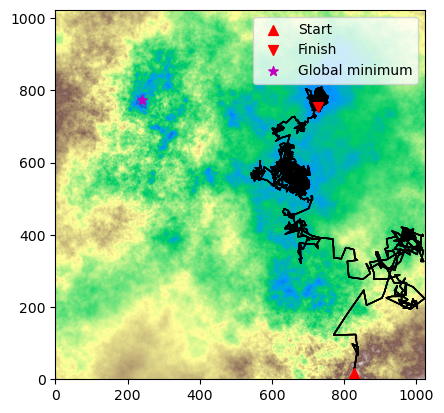

In [2]:
import multifractal_gd.gd_sim as gd_sim
import numpy as np
from scipy.io import loadmat

seed = 0
np.random.seed(seed)

##### Set parameters for simulation #####
lpath = 'data/multifractional_brownian_surface/landscape.mat' # Path to landscape
landscape = loadmat(lpath)["landscape"]
T = 10000 # Number of iterations
lr = 1000 # Learning rate
# xystart = [500, 500] # Starting position at coordinates
xystart = np.flip(np.unravel_index(np.argmax(landscape, axis=None), landscape.shape) + np.random.randn(2)) # Starting position near the global maximum
save_results = True 
save_path = "data/multifractional_brownian_surface/trajectory.mat" # Path for saving

##### Simulating GD #####
gd_sim.simulate_GD(lpath, T, lr, xystart, save_results=save_results, save_path=save_path)

##### First look #####
gd_sim.plot_trajectory(save_path)

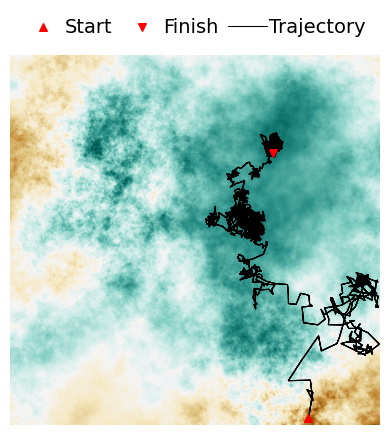

In [12]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
data = loadmat("data/multifractional_brownian_surface/trajectory.mat")
landscape = data["landscape"]
ax.imshow(landscape, cmap='BrBG_r', origin='lower', rasterized=True)

labelled = False 
traj = data["trajectory"]
segments = data["segments"]
lw = 0.75
for elem in segments:
    if not elem[-1]:
        if not labelled:
            ax.plot(elem[0].flatten(), elem[1].flatten(), color='k', linewidth=lw, zorder=1, label='Trajectory')
            labelled=True
        else:
            ax.plot(elem[0].flatten(), elem[1].flatten(), color='k', linewidth=lw, zorder=1)
    else:
        ax.plot(elem[0][0][:2].flatten(), elem[1][0]
                [:2].flatten(), color='k', linewidth=lw, zorder=1, rasterized=True)
        ax.plot(elem[0][0][2:4].flatten(), elem[1][0]
                [2:4].flatten(), color='k', linewidth=lw, zorder=1, rasterized=True)
    if len(elem[0][0]) == 6:
        ax.plot(elem[0][0][4:6].flatten(), elem[1][0]
                [4:6].flatten(), color='k', linewidth=lw, zorder=1, rasterized=True)
# Markers
ax.scatter(traj[0, 0], traj[0, 1], s=30, c='r',
            marker='^', label='Start', zorder=2, rasterized=True)
ax.scatter(traj[-1, 0], traj[-1, 1], s=30, c='r',
            marker='v', label='Finish', zorder=2, rasterized=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=3, fontsize=14, columnspacing=0.5, handletextpad=0.1, frameon=False)

ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# fig.savefig("figures/trajectory.pdf", dpi=600, bbox_inches='tight')
plt.show()

# Calculating TAMSD

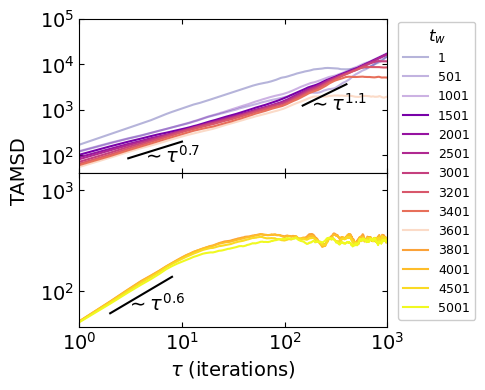

In [18]:
from scipy.io import savemat
import matplotlib.pyplot as plt
from multifractal_gd.general_tools import squarify
import multifractal_gd.msd_tools as msd_tools

##### Get trajectory #####
coords = loadmat("data/multifractional_brownian_surface/trajectory.mat")["trajectory_continuous"]

##### Set parameters for calculating TAMSD #####
waiting_times = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3200, 3400, 3600, 3800, 4000, 4500, 5000]) 
tau = 1000
tau = [tau] * waiting_times.shape[0]
windowsize = 3000

##### Calculation #####
xs, ys = msd_tools.calculate_TAMSD(coords, waiting_times, tau, windowsize)
savemat("data/multifractional_brownian_surface/TAMSD.mat",{"xs": xs, "ys": ys})

# Plot configurations
SMALLER_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Path to directory with tamsd mat files
path = "data/multifractional_brownian_surface/TAMSD.mat"
data = loadmat(path)
xs = data["xs"]
ys = data["ys"]
waiting_times =  (np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3200, 3400, 3600, 3800, 4000, 4500, 5000]) + 1).tolist()

# Colour map
fade_out = [0,1,2,9] # For clarity, fade some overlapping TAMSD lines; these still have super-diffusive parts with exponents around 1.3
transition = 10
cmap = plt.get_cmap("plasma")
regime1 = np.linspace(0,transition/len(xs),transition-1,endpoint=False)
regime2 = np.linspace(transition/len(xs), 1, len(xs) - transition + 1, endpoint=True)
colors = [cmap(i) for i in regime1] + [cmap(i) for i in regime2]
# Figure
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8.27,4)) 
squarify(fig)
ax1, ax2 = ax 
# Plot
for i in range(len(waiting_times)):
    if i in fade_out:
        alpha = 0.3
        lw = 1.5
    else:
        alpha = 1
        lw = 1.5
    if i < transition:
        ax1.loglog(xs[i], ys[i], c=colors[i], label=str(waiting_times[i]), alpha=alpha, linewidth=lw)
    elif i >= transition:
        ax2.loglog(xs[i], ys[i], c=colors[i], label=str(waiting_times[i]), alpha=alpha, linewidth=lw)
        
# Eye guides
X = np.array([3,10])
Y = X**0.7*40
ax1.plot(X,Y, 'k')
fig.text(0.39, 0.52, r'$\sim \tau^{0.7}$')
X = np.array([2,8])
Y = X**0.6*40
ax2.plot(X,Y, 'k')
fig.text(0.37, 0.15, r'$\sim \tau^{0.6}$')
X = np.array([150,400])
Y = X**1.1*5
fig.text(0.59, 0.65, r'$\sim \tau^{1.1}$')
ax1.plot(X,Y, 'k')

# Legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
legend = fig.legend(lines, labels, loc=5, bbox_to_anchor=(0.8,0.5), framealpha=1, title=r"$t_w$", fontsize=9, ncol=1)
plt.setp(legend.get_title(),fontsize=12)
# Appearance
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(axis="both",which="both",direction="in", top=True, right=True)
ax1.set_yticks([1e2,1e3,1e4,1e5])
ax2.tick_params(axis="both",which="both",direction="in", top=True, right=True)
ax2.minorticks_off()
ax1.set_xlim([1,1e3])
ax2.set_xlim([1,1e3])
ax2.set_ylim(top=1.5e3)
ax2.set_xlabel(r"$\tau$ (iterations)")
fig.text(0.23, 0.5, 'TAMSD', va='center', rotation='vertical')
plt.show()
# fig.savefig("figures/TAMSD.pdf", dpi=600, bbox_inches='tight')

# Edge of stability analysis

Note to compare time-evolution of the loss for multiple trajectories, 1) save simulation results for multiple trajectories with various learning rates, 2) for each trajectory, find loss along trajectory, 3) plot. 

In [ ]:
import multifractal_gd.gd_sim as gd_sim
import numpy as np
from multifractal_gd.hessian_tools import hessian, diagonalise_hessian
from scipy.io import loadmat
from scipy import interpolate
# Load a landscape
lpath = 'data/multifractional_brownian_surface/landscape.mat' # Path to landscape
landscape = loadmat(lpath)["landscape"]

# Find leading Hessian eigenvalue on landscape
hess = hessian(landscape) # calculate hessian at each point
eigenvalues = diagonalise_hessian(hess) # Calculate eigenvalues at each point
leading_eig = np.squeeze(np.max(np.abs(eigenvalues), axis=1)) # Leading eigenvalue at each point
f = interpolate.interp2d(np.arange(leading_eig.shape[0]), np.arange(
    leading_eig.shape[1]), leading_eig, kind='linear') # function for linear interpolation

# Range of learning rates
lrs = np.logspace(np.log10(1), np.log10(10000), endpoint=True, num=40)

# Save results across many trials
leading_eig_vals = np.zeros((len(lrs), 10, 100)) # lr x trial x last 100 leading eigs
for i in range(len(lrs)):
    lr = lrs[i]
    for seed in range(leading_eig_vals.shape[1]):
        np.random.seed(seed)
        T = 5000 # Number of iterations
        
        # Starting near global maximum
        xystart = np.flip(np.unravel_index(np.argmax(landscape, axis=None), landscape.shape) + np.random.randn(2))
        save_results = True
        save_path = "data/multifractional_brownian_surface/eos.mat" # Path for saving
        gd_sim.simulate_GD(lpath, T, lr, xystart, save_results=save_results, save_path=save_path)
        data = loadmat("data/multifractional_brownian_surface/eos.mat")
        landscape = data["landscape"]
        traj = data["trajectory"][-100:,:]
        for j in range(traj.shape[0]):
            x,y = traj[j,:]
            leading_eig_vals[i, seed, j] = f(x,y) 
# savemat("data/multifractional_brownian_surface/eos.mat", {"lrs": lrs, "leading_eig": leading_eig_vals})

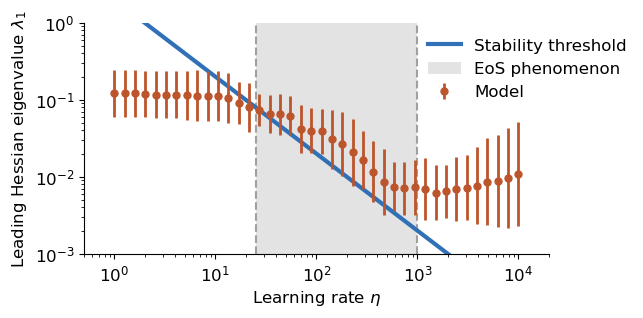

In [10]:
from multifractal_gd.general_tools import squarify
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

BIGGER_SIZE = 12
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Each trial has a mean and std for the leading eigenvalue 
# Compute the average of these across the trials
data = loadmat("data/multifractional_brownian_surface/eos.mat")
lrs = data["lrs"].flatten()
leading_eig_vals = data["leading_eig"]

avg_res = np.zeros(len(lrs))
std_res = np.zeros(len(lrs))
for i in range(len(lrs)):
    res = leading_eig_vals[i,:,:]
    avg_res[i] = np.mean(np.mean(np.log10(res), axis=0))
    std_res[i] = np.mean(np.std(np.log10(res), axis=0)) * 1.96

# Convert errorbars to linear values
err_up = 10**(avg_res + std_res) - 10**avg_res
err_down = 10**avg_res - 10**(avg_res - std_res)
err = np.vstack((err_down, err_up))

fig, ax = plt.subplots()
fig.set_size_inches(6,3)

ax.errorbar(lrs, 10**avg_res, err, marker='o', linestyle='', color='#BC552C', label='Model', capsize=0, elinewidth=2, markersize=5, zorder=3)
ax.plot(lrs, 2/lrs, '-', c='#3070B7', label='Stability threshold', linewidth=3, zorder=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Learning rate $\eta$')
ax.set_ylabel(r'Leading Hessian eigenvalue $\lambda_1$')

ax.axvspan(xmin=25, xmax=1000, ymin=0, ymax=1, color='#DDDDDD', alpha=0.8, lw=0, label=r'EoS phenomenon')
ax.vlines(x=[25,1000], ymin=0.001, ymax=1, color='#A0A0A0', linestyle='--', zorder=1)

ax.set_ylim([0.001,1])
ax.set_xlim([5e-1,2e4])

ax.spines[['right', 'top']].set_visible(False)

ax.legend(loc=5, bbox_to_anchor=(1.2,0.8), fontsize=12, ncol=1, frameon=False)
# fig.savefig("figures/edge_of_stability.pdf", dpi=600, bbox_inches='tight')
plt.show()

# Chaos

In [ ]:
import numpy as np
from scipy.io import loadmat
import multifractal_gd.gd_sim as gd_sim
import matplotlib.pyplot as plt

##### Parameters #####
lr = 1000 # For positive MLE, choose a learning rate that is beyond stability threshold
d0 = 0.1 # Initial small separation
T = 10 # Calculate exponent after T iterations
direction = np.array([1,0]) # Arbitrary direction of perturbation

##### Simulation using Sprott's algorithm #####
# Load landscape
landscape = loadmat("data/multifractional_brownian_surface/landscape.mat")["landscape"]

data = loadmat("data/multifractional_brownian_surface/trajectory.mat")
traj = data["trajectory"]
start = traj[5000,:] # Arbitrary starting point at 5000th iteration

n_trials = 100 # Number of trials
n_ests = 100 # Number of estimates of MLE per trial
lyapunov_exponents = np.zeros(shape=(n_trials, n_ests))
# n_trials random starting points (for bootstrap mean and 95% confidence interval calculation)
for i in range(n_trials):
    # Perturb starting point
    if i == 0:
        perturbation = np.array([0,0])
    else:
        perturbation = np.random.randn(2)
    start += perturbation
    # Calculate 100 estimates
    for j in range(n_ests):
        perturbed_start = start + direction * d0
        end = gd_sim.simulate_GD(landscape, T, lr, start, save_results=False)["trajectory"][-1,:]
        perturbed_end = gd_sim.simulate_GD(landscape, T, lr, perturbed_start, save_results=False)["trajectory"][-1,:]
        d1 = np.linalg.norm(perturbed_end - end)
        lyapunov_exponents[i,j] = np.log(d1/d0)/T
        # Update start and direction
        direction = (perturbed_end - end)/d1
        start = end

##### Visualisation #####
trials = np.arange(1,101)
X = trials
fig, ax = plt.subplots()
for i in range(lyapunov_exponents.shape[0]):
    Y = np.cumsum(lyapunov_exponents[i,:]) / trials
    ax.plot(X, Y)
ax.set_xlim([0,100])
ax.set_xlabel("n")
ax.set_ylabel("Maximal Lyapunov exponent")
plt.show()

##### Bootstrap results #####
np.random.seed(0)
estimates = lyapunov_exponents[:,-1].flatten()

# Bootstrap resampling to find confidence intervals
N = 100
N_expts = 10000
bootstrap_mean = []
for i in range(N_expts):
    indices = np.random.randint(N, size=N)
    bootstrap_mean.append( np.mean(estimates[indices]) )
print(np.mean(bootstrap_mean)) # Estimate of the maximal Lyapunov exponent
print(np.percentile(bootstrap_mean, [2.5, 97.5])) # 95 percent confidence interval

# Fractional diffusion theory

Note to fit the prediction of fractional diffusion theory in the second regime, 1) create fractal landscapes with fixed Holder exponent, 2) simulate GD trajectory on each landscape, 3) calculate TAMSD curves for each trajectory, 4) for each case, select a curve in the second regime, 5) fit the prediction of fractional diffusion theory via normal fitting procedures (e.g., least squares). 

Below we will simply plot an example TAMSD curve in second regime, and demonstrate the numerical solution of the fractional Langevin equation.

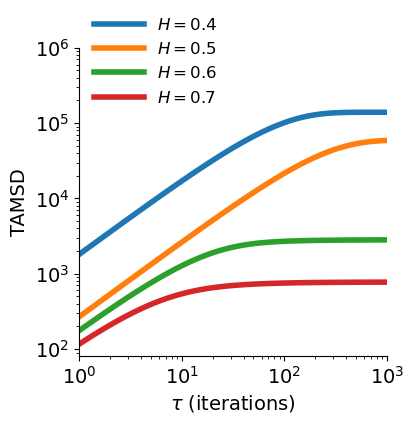

In [26]:
import multifractal_gd.general_tools as general_tools
import matplotlib.pyplot as plt
import numpy as np
from multifractal_gd.general_tools import squarify

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# All on one figure
plt.rc('legend', fontsize=10)    # legend fontsize
fig, ax = plt.subplots(figsize=(8.27,4))

# H = 0.4
scaling = 8
limiting_var = 8719.55768961665
C = 0.013
H = 0.5
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd = []
for t in tau:
    msd.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd = np.array(msd) * 2 * limiting_var
ax.loglog(tau, msd*scaling, '-', linewidth=4, label=r'$H=0.4$')

# H = 0.5
scaling = 1
limiting_var = 29757.746786940213
C = 0.0045
H = 0.5
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd = []
for t in tau:
    msd.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd = np.array(msd) * 2 * limiting_var
ax.loglog(tau, msd*scaling, '-', linewidth=4, label=r'$H=0.5$')

# H = 0.6
scaling = 1
limiting_var = 1414.0634658409645
C = 0.06
H = 0.6
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd = []
for t in tau:
    msd.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd = np.array(msd) * 2 * limiting_var
ax.loglog(tau, msd*scaling, '-', linewidth=4, label=r'$H=0.6$')

# H = 0.7
scaling = 0.3
limiting_var = 1293.9940982446158
C = 0.15
H = 0.7
a = 2-2*H
tau = np.logspace(0, 3, 100)
msd = []
for t in tau:
    msd.append( 1 - general_tools.mittag_leffler(-C*t, a) )
msd = np.array(msd) * 2 * limiting_var
ax.loglog(tau, msd*scaling, '-', linewidth=4, label=r'$H=0.7$')


ax.set_xlim([1,1000])
ax.set_ylim(top=1e6)
ax.set_ylabel("TAMSD")
ax.set_xlabel(r"$\tau$ (iterations)")
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(0.5,1.15), handlelength=3)
ax.spines[['right', 'top']].set_visible(False)
squarify(fig)
# fig.savefig("figures/subdiffusion_FLE.pdf", dpi=600, bbox_inches='tight')
plt.show()

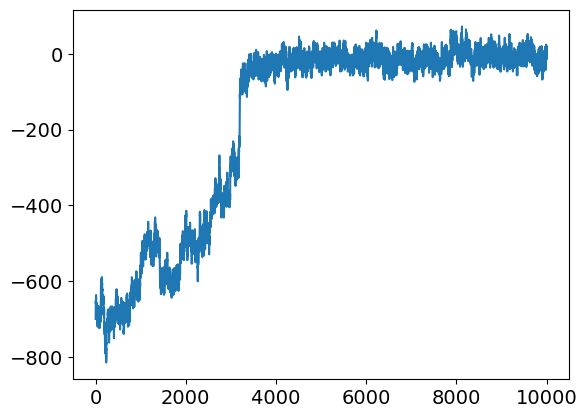

In [27]:
import numpy as np
from multifractal_gd.numerical_tools import integrate_overdamped_FLE
import matplotlib.pyplot as plt

def harmonic_gradient(x, k):
    return k*x

def tilted_washboard_gradient(x, amplitude, period, bias):
    return 2*np.pi*amplitude/period * np.sin(2*np.pi*x/period) - bias

def combined_gradient(x, amplitude, period, bias, radius, k):
    if np.abs(x) < radius:
        return harmonic_gradient(x,k)
    elif x < - radius:
        return tilted_washboard_gradient(x, amplitude, period, bias)
    else:
        return -tilted_washboard_gradient(x, amplitude, period, bias)

amplitude = 1e-4; period = 1e2; bias = 1e-5; radius = 200; k = 5e-7 
x0 = -7e2; T = 10000; eta = 1000; H = 0.7; beta = 5e6; seed = 0

gradient_func = lambda x: combined_gradient(x, amplitude, period, bias, radius, k)
trajectory = integrate_overdamped_FLE(x0, T, eta, H, beta, gradient=gradient_func, seed=seed)

plt.plot(trajectory)
plt.show()

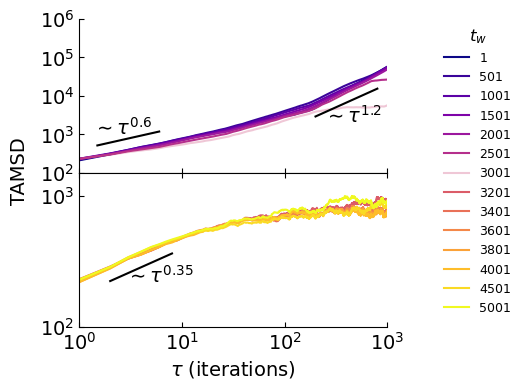

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from multifractal_gd.general_tools import squarify
from multifractal_gd.numerical_tools import calculate_TAMSD

waiting_times = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3200, 3400, 3600, 3800, 4000, 4500, 5000])
tau = [1000] * len(waiting_times)
windowsize = 3000
xs, ys = calculate_TAMSD(trajectory, waiting_times, tau, windowsize)

# Plot configurations
SMALLER_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Path to directory with tamsd mat files
waiting_times =  (np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3200, 3400, 3600, 3800, 4000, 4500, 5000]) + 1).tolist()

# Colour map
fade_out = [6] # For clarity, fade some overlapping TAMSD lines
transition = 7
cmap = plt.get_cmap("plasma")
regime1 = np.linspace(0,transition/len(xs),transition-1,endpoint=False)
regime2 = np.linspace(transition/len(xs), 1, len(xs) - transition + 1, endpoint=True)
colors = [cmap(i) for i in regime1] + [cmap(i) for i in regime2]
# Figure
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8.27,4)) 
squarify(fig)
ax1, ax2 = ax 
# Plot
for i in range(len(waiting_times)):
    if i in fade_out:
        alpha = 0.3
        lw = 1.5
    else:
        alpha = 1
        lw = 1.5
    if i < transition:
        ax1.loglog(xs[i], ys[i], c=colors[i], label=str(waiting_times[i]), alpha=alpha, linewidth=lw)
    elif i >= transition:
        ax2.loglog(xs[i], ys[i], c=colors[i], label=str(waiting_times[i]), alpha=alpha, linewidth=lw)
        
# Eye guides
X = np.array([1.5,6])
Y = X**0.6*400
ax1.plot(X,Y, 'k')
fig.text(0.33, 0.59, r'$\sim \tau^{0.6}$')
X = np.array([2,8])
Y = X**0.35*175
ax2.plot(X,Y, 'k')
fig.text(0.37, 0.22, r'$\sim \tau^{0.35}$')
X = np.array([200,800])
Y = X**1.2*5
fig.text(0.61, 0.62, r'$\sim \tau^{1.2}$')
ax1.plot(X,Y, 'k')

# Legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
legend = fig.legend(lines, labels, loc=5, bbox_to_anchor=(0.85,0.5), framealpha=1, title=r"$t_w$", fontsize=9, ncol=1, frameon=False)
plt.setp(legend.get_title(),fontsize=12)
# Appearance
plt.subplots_adjust(wspace=0, hspace=0)
ax1.tick_params(axis="both",which="both",direction="in")
ax1.set_yticks([1e2,1e3,1e4,1e5,1e6])
ax2.tick_params(axis="both",which="both",direction="in", top=True)
ax2.minorticks_off()
ax1.set_xlim([1,1e3])
ax2.set_xlim([1,1e3])
ax2.set_ylim(bottom=1e2, top=1.5e3)
ax2.set_xlabel(r"$\tau$ (iterations)")
fig.text(0.23, 0.5, 'TAMSD', va='center', rotation='vertical')
# Remove top and right spines
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right']].set_visible(False)
plt.show()
# fig.savefig("figures/TAMSD_numerical.pdf", dpi=600, bbox_inches='tight')